In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
#!pip install tensorflow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


drive.mount('/content/drive')

#Get directory paths
base_dir = "/content/drive/MyDrive/ML_project_fall_25/dataset/"

# Update paths for your generators
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "validate")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

#read images from directory and process them in batches of BATCH_SIZE, resize to (224,224)
BATCH_SIZE = 32
target_size = (224,224) #this size is best for transfer learning

#dataset to read from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=False
)

num_classes = train_ds.element_spec[1].shape[-1]
for i,name in enumerate(train_ds.class_names):
    print(f"{i}: {name}")
print("Number of Classes:", num_classes)

train_ds = train_ds.shuffle(2000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Found 51387 files belonging to 15 classes.
Found 11008 files belonging to 15 classes.
Found 11012 files belonging to 15 classes.
0: apple fm train
1: apple fresh train
2: apple rotten train
3: banana fm train
4: banana fresh train
5: banana rotten train
6: grape fm train
7: grape fresh train
8: grape rotten train
9: mango fm train
10: mango fresh train
11: mango rotten train
12: orange fm train
13: orange fresh train
14: orange rotten train
Number of Classes: 15


In [ ]:
#Transfer Learning - using EfficientNetB0 because its good for 224 x 224 and fast on T4 GPU

from tensorflow.keras.applications import EfficientNetB0

basemodel = EfficientNetB0(
    weights = 'imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
#for feature extraction
basemodel.trainable=False

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow as tf

mixed_precision.set_global_policy('mixed_float16')

augment = tf.keras.Sequential([
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(0.3),
    layers.RandomSaturation(0.3),
    layers.RandomHue(0.05)
])

inputs = layers.Input(shape=(224,224,3), dtype=tf.float32)
x = augment(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = basemodel(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
model = models.Model(inputs,outputs)


for layer in model.layers[-80:]:
    layer.trainable = True

In [ ]:
import tensorflow as tf

model.compile(optimizer=tf.keras.optimizers.Adam(0.00018791),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 4,026,763 (15.36 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 5524s 774ms/step - accuracy: 0.8288 - loss: 0.5152 - val_accuracy: 0.7927 - val_loss: 0.8243
Epoch 2/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 203s 70ms/step - accuracy: 0.9766 - loss: 0.0692 - val_accuracy: 0.7962 - val_loss: 0.9449
Epoch 3/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 195s 70ms/step - accuracy: 0.9855 - loss: 0.0397 - val_accuracy: 0.7695 - val_loss: 1.0779
Epoch 4/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 195s 71ms/step - accuracy: 0.9903 - loss: 0.0274 - val_accuracy: 0.7567 - val_loss: 1.0381
Epoch 5/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 193s 70ms/step - accuracy: 0.9918 - loss: 0.0240 - val_accuracy: 0.7981 - val_loss: 1.3407
Epoch 6/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 193s 70ms/step - accuracy: 0.9943 - loss: 0.0178 - val_accuracy: 0.8190 - val_loss: 1.2399
Epoch 7/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 193s 70ms/step - accuracy: 0.9953 - loss: 0.0163 - val_accuracy: 0.8189 - val_loss: 1.3789
Epoch 8/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 192s 70ms/step - accuracy

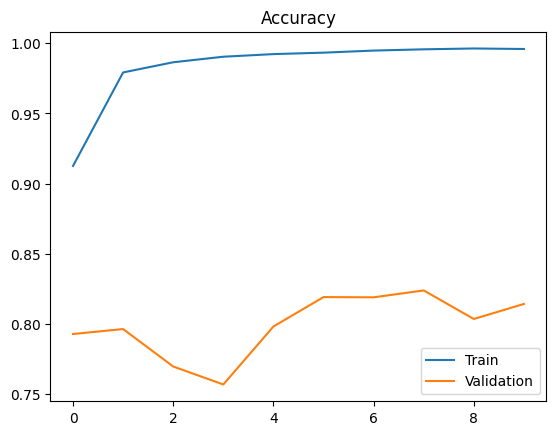

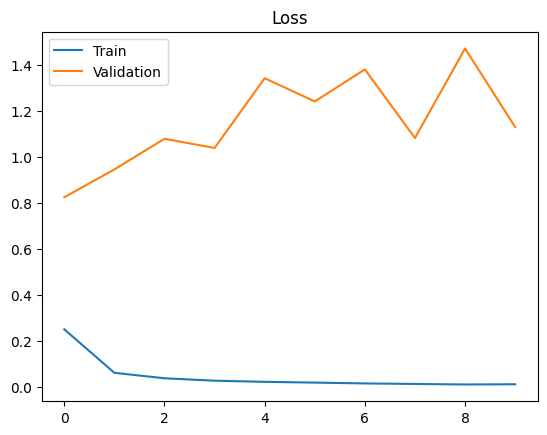

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(["Train", "Validation"])
plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)

print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)

344/344 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8300 - loss: 0.8595
345/345 ━━━━━━━━━━━━━━━━━━━━ 979s 3s/step - accuracy: 0.8957 - loss: 0.4405
Validation Accuracy: 0.8141351938247681
Test Accuracy: 0.9085543155670166


In [ ]:
from sklearn.metrics import classification_report
# Collect predictions
y_true = []
y_pred = []

for x, y in test_ds:
    preds = model.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y.numpy(), axis=1))

print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

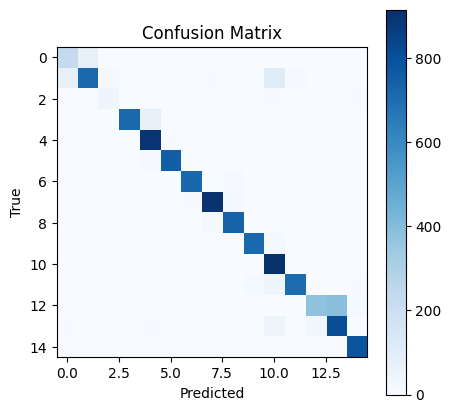

<Axes: >

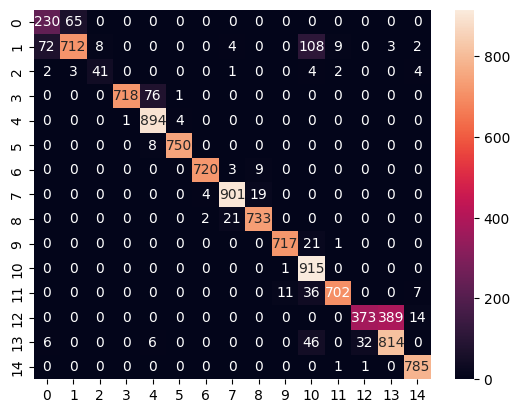

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#class 0,3,12 (apple/banana/orange fm) gets confused with class 1,4,13(apple,banana,orange fresh)
sns.heatmap(cm, annot=True, fmt="d")

Found 51387 files belonging to 15 classes.


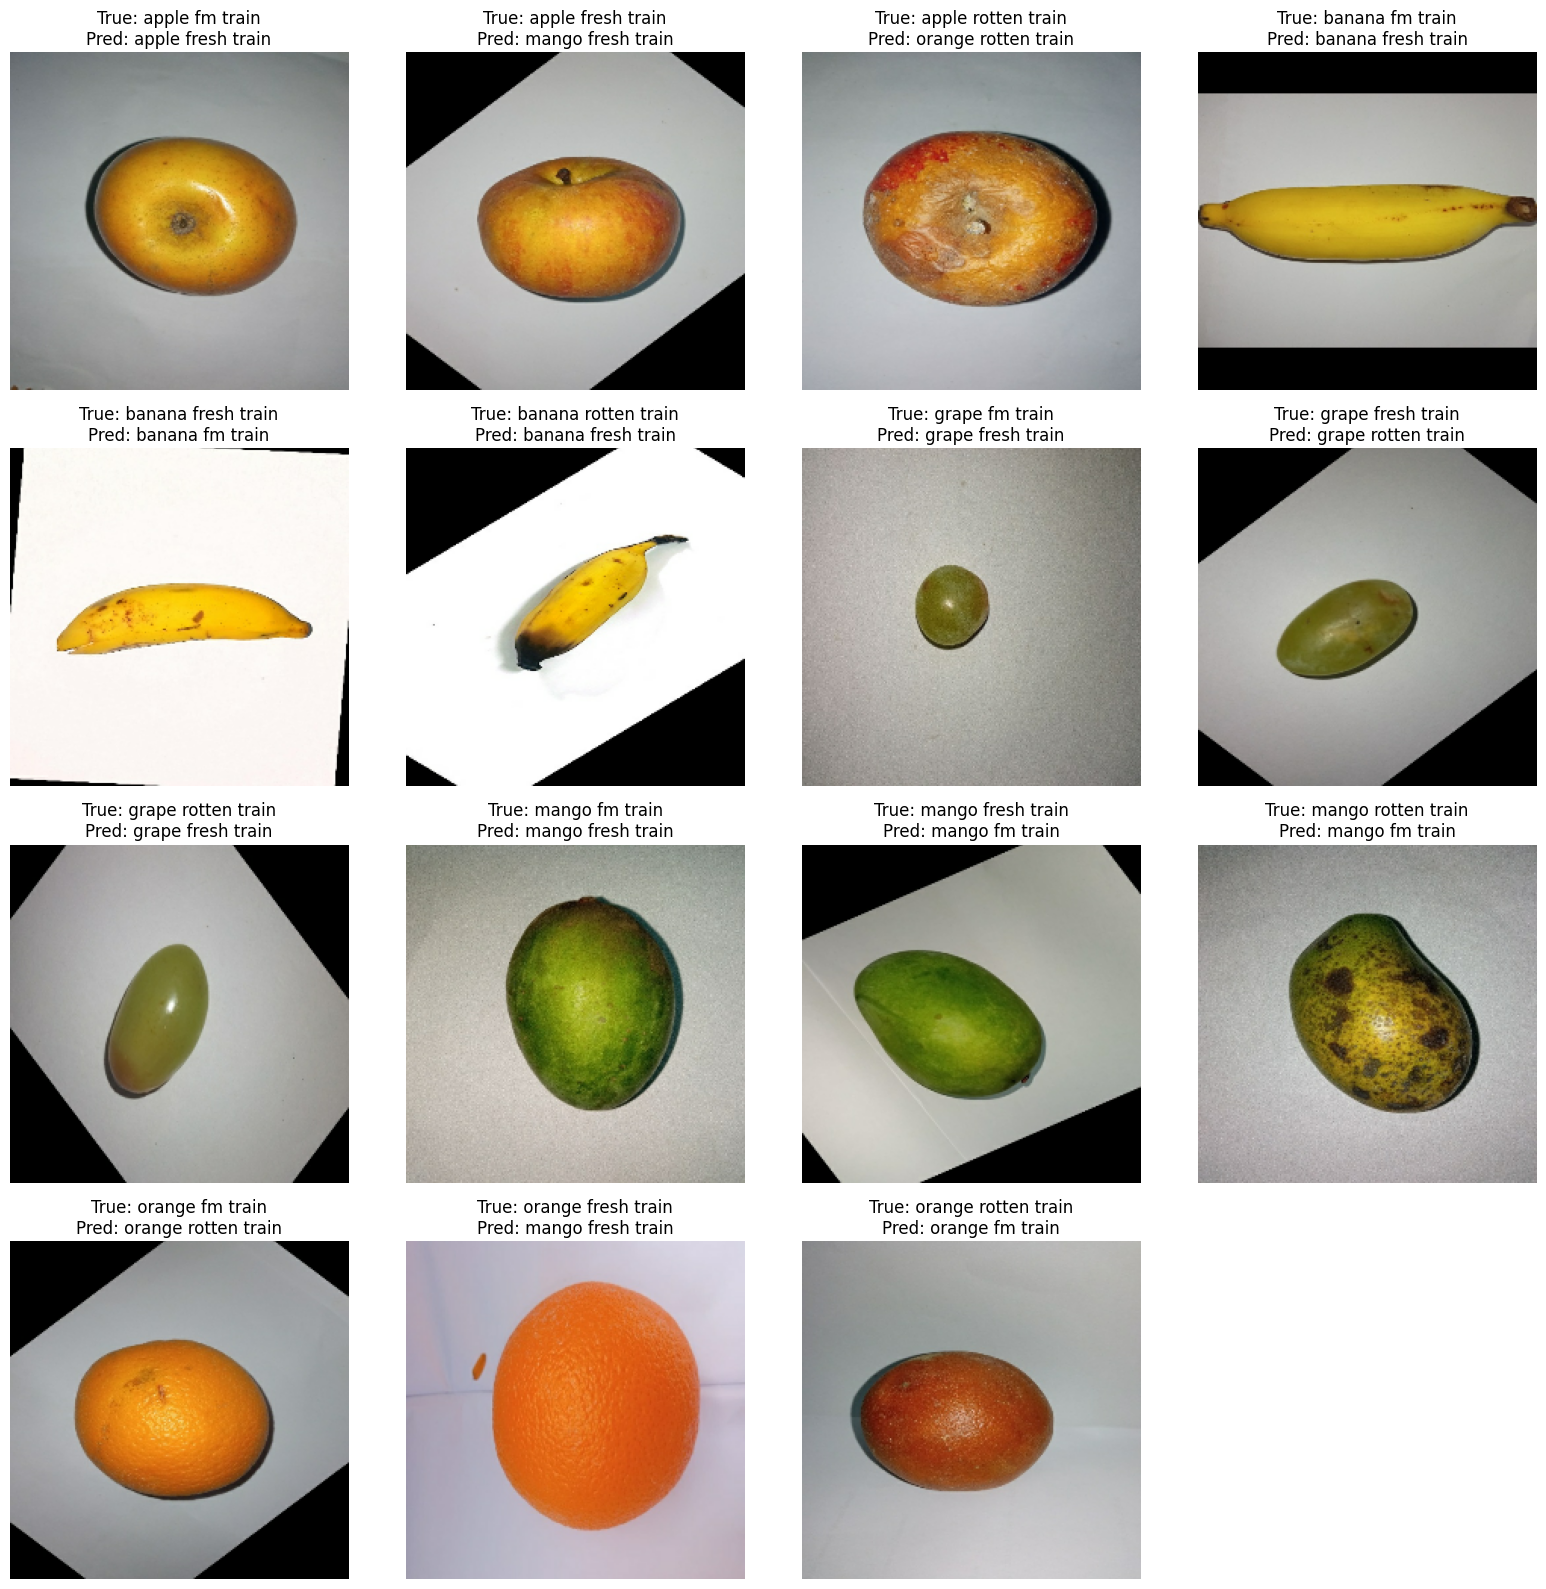

In [ ]:
train_ds_class_names = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=False
)
class_names = train_ds_class_names.class_names
misclassified_samples = {}
num_samples = 1

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()
    true_classes = tf.argmax(labels, axis=1).numpy()
    for i in range(len(images)):
        true = true_classes[i]
        pred = predicted_classes[i]
        if true != pred:
            if true not in misclassified_samples:
                misclassified_samples[true] = []

            if len(misclassified_samples[true]) < num_samples:
                misclassified_samples[true].append({
                    'image': images[i].numpy(),
                    'true_label': true,
                    'predicted_label': pred
                })
    if len(misclassified_samples) >= num_classes and all(len(v) == num_samples for v in misclassified_samples.values()):
        break

plt.figure(figsize=(16, 16))
index=1
for class_name, example_list in misclassified_samples.items():
    if not example_list:
        continue
    example = example_list[0]
    img = example['image']
    true = example['true_label']
    pred = example['predicted_label']
    plt.subplot(4, 4, index)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
    plt.axis("off")
    index += 1

plt.tight_layout()
plt.show()

In [ ]:
model.save("final__model_with_hp.keras")